In [3]:
import pandas as pd
import datetime as dt
import numpy as np
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.decomposition import PCA

import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
import nltk
import string
nltk.download('stopwords')   

from gensim.models import Word2Vec

from bokeh.plotting import *
from bokeh.models import *
from bokeh.layouts import column, row
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

[nltk_data] Downloading package stopwords to /Users/Jean-
[nltk_data]     BaptistePROST/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Word Analysis
This part focuses on the textual content and representation of the tweets. The aim is to characterize the typical tweet of each troll category. First, the tweets are cleaned, a vocabulary as well as a colelction of hash-tags are build. Then a Word2Vec model is used to gather words by 'concepts'. Finally, each tweet is represented by the words it contains. A classifier is build to distinguish right and left trolls. 

## Preprocessing

### Data import and cleaning

The data is already pretty clean. We Select only the 'LeftTroll' and 'RightTroll' tweet after 2014.

In [1]:
def get_date(x):
    """From string to datatime.date()"""
    return dt.datetime.strptime(x, '%m/%d/%Y %H:%M').replace(minute=0, hour=0, second=0)

def cleaning_content(df,  right=True, left=True):
    df_tmp=df[df.language=='English'].drop(columns={'harvested_date', 'language'})
    df_tmp=df.loc[:,['publish_date','content', 'account_category']]

    #category
    if not left:
        df_tmp=df_tmp[(df_tmp.account_category=='RightTroll')]
    elif not right:
        df_tmp=df_tmp[(df_tmp.account_category=='LeftTroll')]
    else:        
        df_tmp=df_tmp[(df_tmp.account_category=='RightTroll') | (df_tmp.account_category=='LeftTroll')  ]

    #date 
    df_tmp['publish_date']=df_tmp.publish_date.apply(lambda x: get_date(x))
    df_tmp=df_tmp[df_tmp.publish_date > dt.datetime(2014,10,1,0,0,0)].drop(columns='publish_date') #selecting after Oct 2014

    return df_tmp

Loading the data and merging (9) datasets.

In [4]:
data='Data/russian-troll-tweets/IRAhandle_tweets_'
    
df=pd.DataFrame()
for dataset in range(1,9):
    df_tmp=cleaning_content(pd.read_csv(data+str(dataset)+'.csv'))
    df=df.append(df_tmp, ignore_index=True)

In [5]:
print('There are {} tweets'.format(df.shape[0]))
df.head()

There are 1131960 tweets


,content,account_category
0,"""We have a sitting Democrat US Senator on tria...",RightTroll
1,Marshawn Lynch arrives to game in anti-Trump s...,RightTroll
2,Daughter of fallen Navy Sailor delivers powerf...,RightTroll
3,JUST IN: President Trump dedicates Presidents ...,RightTroll
4,"19,000 RESPECTING our National Anthem! #StandF...",RightTroll


### Tweet text cleaning

The text is process as follow:
* hastags are exctracted (analysis to be done ...)
* the text is cleaned from punctuation (execpt '-')
* words are set to lower keys
* words that are not written with 'latin' caracters (emojiis, foreign alphabet...) are removed
* words that start/end with number are discarder
* links are discarded (start with 'http...')

In [21]:
link_numbers=('http', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '-') #
stemmer = PorterStemmer()
stop_w=[word.replace('\'','') for word in stopwords.words('english')]+ ['', '&amp', 'amp','rt'] 

def tokenize(text):
    """Split the the tweet into a list of (cleaned words)"""
    text_cleaned = ''.join(ch for ch in text if ch not in '#!"$%&\()*+,./:;<=>?@[\\]^_{|}~\'').split(' ') 
    
    words= [word.lower().encode('ascii',errors='ignore').decode() for word in text_cleaned \
            if not ( (word.startswith(link_numbers)) | (word.endswith(link_numbers)) )]
    
    words=[stemmer.stem(word) for word in words if word not in stop_w ]
        
    if len(words) > 0:
        return words
    else: #tweets that contains only links or emojiis ...
        pass

def top_vocabulary(text, top=10): #### not used ###
    words = [stemmer.stem(word) for word in tokenize(text) if word not in stop_w] 
    voc=pd.DataFrame.from_dict(Counter(words), orient='index')\
            .rename(columns={0:'Count'})\
            .sort_values(by='Count', ascending=False)[:top]
    return voc

def build_vocab(tweets, min_occurence=10):
    
    voc_raw=[]
    for words in tweets:
        if words: #if not None
            voc_raw+=words # add to voca
    count_=Counter(voc_raw)
    return [hashtag for hashtag in count_.keys() if count_[hashtag] >= min_occurence]

def word_orientation(df, vocab):
    """Defines if a words have been used more by Right or Left trolls.
    LeftTroll: -1 ≤ score ≤ 1 : RightTroll"""
    
    tot_words=len(vocab)
    words_party= pd.DataFrame(np.zeros(tot_words), columns={'Score'},index=vocab)

    voc=[]
    for tweet in df[(df.Clean_tweet.isnull()==False) & (df.account_category=='RightTroll')].Clean_tweet:
        voc+=tweet
    count=pd.DataFrame.from_dict(Counter(voc), columns={'R'}, orient='index')

    words_party=words_party.merge(count, how='left', right_index=True, left_index=True)

    voc=[]
    for tweet in df[(df.Clean_tweet.isnull()==False) & (df.account_category=='LeftTroll')].Clean_tweet:
        voc+=tweet
    count=pd.DataFrame.from_dict(Counter(voc), columns={'L'}, orient='index')

    words_party=words_party.merge(count, how='left', right_index=True, left_index=True)
    words_party.fillna(0,inplace=True)
    words_party['Score']=words_party.apply(lambda row: (row['R']-row['L'])/(row['R']+row['L']), axis=1)

    return words_party

def get_vocabulary(tweets, min_count=10):
    """Recovers the vocabulary"""
    filename='vocabulary_'+str(min_count)+'.pkl'
    
    try:
        
        with open(filename, 'rb') as voc:
            vocabulary=pickle.load(voc) 
            
    except: 
        vocabulary= build_vocab(tweets)
        
        with open(filename, 'wb') as voc:
            pickle.dump(vocabulary, voc, pickle.HIGHEST_PROTOCOL) #saving the voc
            
    return vocabulary
        

In [20]:
df['Clean_tweet']=df.apply(lambda row: tokenize(row['content']), axis=1) #list of words for each tweet
vocabulary=get_vocabulary(df.Clean_tweet, min_count=10)

Each word gets characterize by a *Score* that should represent it category: <br>
        
        LeftTroll: -1 ≤ score ≤ 1 : RightTroll
        
To get rid of neutral words, we take only words that are characteristic of one the two groups : 

        |Score| ≥ 0.25

In [309]:
#quantifies de correlation between each category (right or left)
vocabulary_oriented=word_orientation(df, vocabulary)

#take words that are oriented. Remove neutral words : |orientation| < 0.25
vocabulary_oriented=vocabulary_oriented[np.abs(vocabulary_oriented.Score) >= 0.25] 

#remove words that are not kept in the vocabulary oriented
df['Clean_tweet']=df.Clean_tweet.apply(lambda list_word: \
                                       [word for word in list_word if word in vocabulary_oriented.index]\
                                        if list_word else None)


### Hashtags

In [ ]:
def get_hastag_collection(text, nb_min=10):
    """Defines the collection of hastags in the entire dataset. 
    Try to load the hastag list if its available"""
    
    filename='hastag_collection_count_'+str(nb_min)+'.pkl'
    
    try :
        with open(filename, 'rb') as h:
            count_=pickle.load(h) 
            
    except:
        hashtags = []
        text = text.split()
        for words in text:
            new_hash = re.match("#[A-Za-z0-9\-\.\_]+", words)
            if new_hash:
                hashtags.append(new_hash.group(0))
        count_=Counter(hashtags)

        with open(filename, 'wb') as h:
            pickle.dump(count_, h, pickle.HIGHEST_PROTOCOL) #saving the tweet_vect
        
    return [hashtag for hashtag in count_.keys() if count_[hashtag] >= nb_min]

def hashtag_extractor(text,hastag_coll):
    """Extract hastags if they happend more than nb_min times (over the whole data)"""
    hashtags = []
    for word in text.split():
        if (word.startswith('#')) & (word.encode('ascii',errors='ignore').decode() in hastag_coll):
            hashtags.append(word.encode('ascii',errors='ignore').decode())
    return hashtags

def hastag_orientation(df, hashtags_collec):
    """Defines if a words have been used more by Right or Left trolls.
    LeftTroll: -1 ≤ score ≤ 1 : RightTroll"""
    
    tot_hash=len(hashtags_collec)
    hash_party= pd.DataFrame(np.zeros(tot_hash), columns={'Score'}, index=hashtags_collec)

    hash_=[]
    for tweet in df[(df.hashtags.isnull()==False) & (df.account_category=='RightTroll')].hashtags:
        hash_+=tweet
    count=pd.DataFrame.from_dict(Counter(hash_), columns={'R#'}, orient='index')

    hash_party=hash_party.merge(count, how='left', right_index=True, left_index=True)

    hash_=[]
    for tweet in df[(df.hashtags.isnull()==False) & (df.account_category=='LeftTroll')].hashtags:
        hash_+=tweet
    count=pd.DataFrame.from_dict(Counter(hash_), columns={'L#'}, orient='index')

    hash_party=hash_party.merge(count, how='left', right_index=True, left_index=True)
    
    hash_party.fillna(0,inplace=True)
    hash_party['Score']=hash_party.apply(lambda row:  (row['R#']-row['L#'])/(row['R#']+row['L#']) \
                                         if ((row['R#']+row['L#']) >0) else 0 , axis=1)

    return hash_party

Exctract hastags that happend more than X (=10) time 

In [99]:
hashtags_collec=get_hastag_collection(' '.join([tweet for tweet in df.content]), 10)

In [12]:
df['hashtags']=df.content.apply(lambda text: hashtag_extractor(text,hashtags_collec))

In [13]:
df.head()

,content,account_category,Clean_tweet,hashtags
0,"""We have a sitting Democrat US Senator on tria...",RightTroll,"[sit, democrat, us, senat, trial, corrupt, bar...",[]
1,Marshawn Lynch arrives to game in anti-Trump s...,RightTroll,"[marshawn, lynch, arriv, game, anti-trump, shi...",[]
2,Daughter of fallen Navy Sailor delivers powerf...,RightTroll,"[daughter, fallen, navi, sailor, deliv, power,...",[#BoycottNFL]
3,JUST IN: President Trump dedicates Presidents ...,RightTroll,"[presid, trump, dedic, presid, cup, golf, tour...",[]
4,"19,000 RESPECTING our National Anthem! #StandF...",RightTroll,"[respect, nation, anthem, standforouranthem]",[#StandForOurAnthem]


In [129]:
#defines a color according to their score
hashtags=hastag_orientation(df, hashtags_collec)
hashtags['colors#'] = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.RdBu(mpl.colors.Normalize()(hashtags['Score'].apply(lambda x: -x).tolist()))
]

In [130]:
hashtags.head()

,Score,R#,L#,colors#
#BoycottNFL,0.937500,93.0,3.0,#7e0722
#StandForOurAnthem,1.000000,12.0,0.0,#67001f
#HipHopAwards,-0.333333,5.0,10.0,#a7cfe4
#Iran,0.748344,264.0,38.0,#bb2a33
#MAGA,0.969174,12265.0,192.0,#6f0220


## Word2Vec

In [310]:
#non empty clean tweet
embedding=100
tweets=df[df.Clean_tweet.isnull()==False]['Clean_tweet'] #take non empty clean tweet
model = Word2Vec(tweets.tolist(), min_count=1, size=embedding)
vocab_model=model.wv.vocab

In [311]:
print(model)

Word2Vec(vocab=23897, size=100, alpha=0.025)


Perfom a PCA on the model's vectors for plotting. Each word gets a color according to its orientation score (defiend above)

In [265]:
word_vec = pd.DataFrame(model.wv.vectors, index=vocab_model) #for tweet vector

# fit a PCA and tke the first 3 PCs
pca = PCA(n_components=3)

result = pd.DataFrame(pca.fit_transform(model.wv.vectors), columns={'X','Y','Z'})
result.index=vocab_model


#defines a color according to their score
result=result.merge(vocabulary_oriented, how='right', right_index=True, left_index=True)
result['colors'] = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.RdBu(mpl.colors.Normalize()(result['Score'].apply(lambda x: -x).tolist()))
]

In [266]:
result.head()

,X,Z,Y,Score,R,L,colors
democrat,-4.835730,0.773477,-0.226426,0.795162,13654.0,1558.0,#b2192b
senat,-4.925029,-0.696265,0.126247,0.661033,7027.0,1434.0,#ca4942
corrupt,-1.130853,0.624839,1.797876,0.756555,4589.0,636.0,#b92732
mainstream,-4.285165,1.834165,1.392716,0.654558,1207.0,252.0,#cc4c43
media,-5.130202,1.575751,-1.391356,0.646228,15156.0,3257.0,#cd4f44


## Plotting:

### Word space (PCA)

In [267]:
# ---- X vs Y ----
pXY = figure(plot_width=450, plot_height=450) # x_axis_type='datetime')
pXY.title.text = 'Tweets topic clusters'

right_word=result[result['Score'] >= 0.5 ]
left_word=result[result['Score']<=-0.5]

source_R = ColumnDataSource(data=right_word)
pXY.scatter(x='X', y='Y', source=source_R, fill_color='colors', legend='Right', fill_alpha=0.6, line_color=None)

source_L = ColumnDataSource(data=left_word)
pXY.scatter(x='X', y='Y', source=source_L, fill_color='colors',legend='Left', fill_alpha=0.6, line_color=None)


pXY.legend.location = 'top_left'
pXY.legend.click_policy='hide'
pXY.xaxis.axis_label='PC1'
pXY.yaxis.axis_label='PC2'

hover_tool=tools.HoverTool(
    tooltips=[('Word', '@index')],
    formatters={'index' : 'printf', },
    mode='mouse'
)

pXY.tools.append(hover_tool)

# ---- X vs Z ----
pXZ = figure(plot_width=450, plot_height=450) # x_axis_type='datetime')
pXZ.title.text = 'Tweets topic clusters'

right_word=result[result['Score'] >= 0.5 ]
left_word=result[result['Score']<=-0.5]

source_R = ColumnDataSource(data=right_word)
pXZ.scatter(x='Y', y='Z', source=source_R, fill_color='colors', legend='Right', fill_alpha=0.6, line_color=None)

source_L = ColumnDataSource(data=left_word)
pXZ.scatter(x='Y', y='Z', source=source_L, fill_color='colors',legend='Left', fill_alpha=0.6, line_color=None)


pXZ.legend.location = 'top_left'
pXZ.legend.click_policy='hide'
pXZ.xaxis.axis_label='PC1'
pXZ.yaxis.axis_label='PC3'

hover_tool=tools.HoverTool(
    tooltips=[('Word', '@index')],
    formatters={'index' : 'printf', },
    mode='mouse'
)

pXZ.tools.append(hover_tool)
output_notebook()

Loading BokehJS ...

In [268]:
show(row(pXY, pXZ))

In [276]:
#some experiment
model.most_similar(stemmer.stem("blacktwitter"))

/Users/Jean-BaptistePROST/miniconda3/envs/ada/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('bankblack', 0.7439147233963013),
 ('blackpow', 0.7347536683082581),
 ('buyblack', 0.7192205190658569),
 ('theroot', 0.6925411224365234),
 ('blackpeopl', 0.6835432052612305),
 ('blackwomen', 0.6801042556762695),
 ('blackprid', 0.6626390218734741),
 ('black-own', 0.6624561548233032),
 ('blacklov', 0.6551076769828796),
 ('blacktw', 0.6532891988754272)]

### Most frequent words & hashtags per category 

In [270]:
top=15
popular_right=result.sort_values(by='R',ascending=False)[:top].sort_values(by='R')
popular_left=result.sort_values(by='L',ascending=False)[:top].sort_values(by='L')

popular_right_h=hashtags.sort_values(by='R#',ascending=False)[:top].sort_values(by='R#')
popular_left_h=hashtags.sort_values(by='L#',ascending=False)[:top].sort_values(by='L#')

In [271]:
#Right trolls:
sourceR=ColumnDataSource(data=popular_right)
pR = figure(plot_width=450, plot_height=450, y_range=popular_right.index.tolist())
pR.hbar(right='R', y='index', height=0.95, color='colors', source=sourceR)
pR.title.text = 'Popular words for RightTrolls'

sourceR_hash=ColumnDataSource(data=popular_right_h)
pR_hash = figure(plot_width=450, plot_height=450, y_range=popular_right_h.index.tolist())
pR_hash.hbar(right='R#', y='index', height=0.95, color='colors#', source=sourceR_hash)
pR_hash.title.text = 'Popular Hastags for RightTrolls'


#Left trolls:
sourceL=ColumnDataSource(data=popular_left)
pL = figure(plot_width=450, plot_height=450, y_range=popular_left.index.tolist()) 
pL.hbar(right='L', y='index', height=0.95, color='colors', source=sourceL, )
pL.title.text = 'Popular words for LeftTrolls'

sourceL_hash=ColumnDataSource(data=popular_left_h)
pL_hash = figure(plot_width=450, plot_height=450, y_range=popular_left_h.index.tolist())
pL_hash.hbar(right='L#', y='index', height=0.95, color='colors#', source=sourceL_hash)
pL_hash.title.text = 'Popular Hastags for LeftTrolls'


#hover settings
hover_tool=tools.HoverTool(
    tooltips=[('Orientation', '@Score')],
    formatters={'Score' : 'printf', },
    mode='mouse'
)

pL.tools.append(hover_tool)
pR.tools.append(hover_tool)
pR_hash.tools.append(hover_tool)
pL_hash.tools.append(hover_tool)

output_notebook()

Loading BokehJS ...

In [272]:
show(gridplot([[pR,pL], [pR_hash, pL_hash]]))

## Tweets representation

Represent each tweet with K components (the number of word embedding dimensions) as the mean of each word's compenents.

In [ ]:
def get_tweet_vec(df,embedding):
    
    filename='tweets_vec_'+str(embedding)+'.pkl'
    try:
        with open(filename, 'rb') as tv:
            tweets_vec=pickle.load(tv)
    except:
    tweets_vec= np.zeros((df.shape[0],embedding)) # nb_words x K 
    zero_vec=np.zeros(embedding)

    for  idx, words in enumerate(df.Clean_tweet):
        if words:  #if not None   
            tweets_vec[idx,:]=np.mean(word_vec.loc[words,:], axis=0) # mean over words-vectors (the weighting is included)
        else:
            tweets_vec[idx,:]=zero_vec

    with open(filename, 'wb') as tv:
        pickle.dump(tweets_vec, tv, pickle.HIGHEST_PROTOCOL) #saving the tweet_vect
    
    return tweets_vec

In [18]:
tweets_vec=get_tweet_vec(df, embedding)

(1131960, 20)

In [ ]:
pca = PCA(n_components=3)

tweet_vec_pca = pd.DataFrame(pca.fit_transform(model.wv.vectors),columns={'X','Y','Z'})
tweet_vec_pca['category']=df.account_category
tweet_vec_pca['colors']=tweet_vec_pca.apply(lambda row: '#ff6347' if row['category']=='RightTroll' else '#1E90FF', axis=1)
tweet_vec_pca['tweet']=df.content

In [ ]:
# ---- PC1 vs PC2 ---- #
pXY = figure(plot_width=500, plot_height=450)
pXY.title.text = 'Tweets topic clusters'


source_pca_R = ColumnDataSource(data=tweet_vec_pca[tweet_vec_pca.category== 'RightTroll'])
pXY.scatter(x='X', y='Y', source=source_pca_R, fill_color='colors', legend='RightTroll', fill_alpha=0.6, line_color=None)

source_pca_L = ColumnDataSource(data=tweet_vec_pca[tweet_vec_pca.category== 'LeftTroll'])
pXY.scatter(x='X', y='Y', source=source_pca_L, fill_color='colors', legend='LeftTroll', fill_alpha=0.6, line_color=None)


pXY.legend.location = 'top_left'
pXY.legend.click_policy='hide'
pXY.xaxis.axis_label='PC1'
pXY.yaxis.axis_label='PC2'

hover_tool=tools.HoverTool(
    tooltips=[('Tweet', '@tweet')],
    formatters={'tweet' : 'printf', },
    mode='mouse'
)

pXY.tools.append(hover_tool)

# ---- PC1 vs PC3 ---- #
pXZ = figure(plot_width=500, plot_height=450)
pXZ.title.text = 'Tweets topic clusters'


source_pca_R = ColumnDataSource(data=tweet_vec_pca[tweet_vec_pca.category== 'RightTroll'])
pXZ.scatter(x='X', y='Z', source=source_pca_R, fill_color='colors', legend='RightTroll', fill_alpha=0.6, line_color=None)

source_pca_L = ColumnDataSource(data=tweet_vec_pca[tweet_vec_pca.category== 'LeftTroll'])
pXZ.scatter(x='X', y='Z', source=source_pca_L, fill_color='colors', legend='LeftTroll', fill_alpha=0.6, line_color=None)


pXZ.legend.location = 'top_left'
pXZ.legend.click_policy='hide'
pXZ.xaxis.axis_label='PC1'
pXZ.yaxis.axis_label='PC3'


pXZ.tools.append(hover_tool)

output_notebook()
show(row(pXY, pXZ))

## Classifier

In [ ]:
def print_scores(scores):
    print("#   ---- Train ----   #\nAccuracy: {:0.3f} ± {:0.3f}\nF1:       {:0.3f} ± {:0.3f}\n#  \
    ---- Test ----    #\nAccuracy: {:0.3f} ± {:0.3f}\nF1:       {:0.3f} ± {:0.3f}"\
       .format(scores['train_accuracy'].mean(), scores['train_accuracy'].std(),\
               scores['train_f1'].mean(), scores['train_f1'].std(),\
               scores['test_accuracy'].mean() , scores['test_accuracy'].std(),\
               scores['test_f1'].mean() , scores['test_f1'].std()))
    
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar
    
#labels {0,1}
labels=df.account_category.apply(lambda string: 1 if string=='RightTroll' else 0)

X_train, X_test, y_train, y_test = train_test_split(tweets_vec, labels, test_size=0.2, shuffle=True)

In [138]:
#model creation
RF= RandomForestClassifier(n_estimators=20, max_depth=15)
    #scores=cross_validate(RF, tweets_vec, labels, cv=5, scoring={'accuracy', 'f1'}, return_train_score=True)
    #print_scores(scores)

In [139]:
parameters = {'n_estimators':range(10,60,10), 'max_depth': range(10,60,10)}
RF_gs = GridSearchCV(RF, param_grid=parameters, cv=5, scoring='accuracy', return_train_score=True)
RF_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(10, 60, 10), 'max_depth': range(10, 60, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

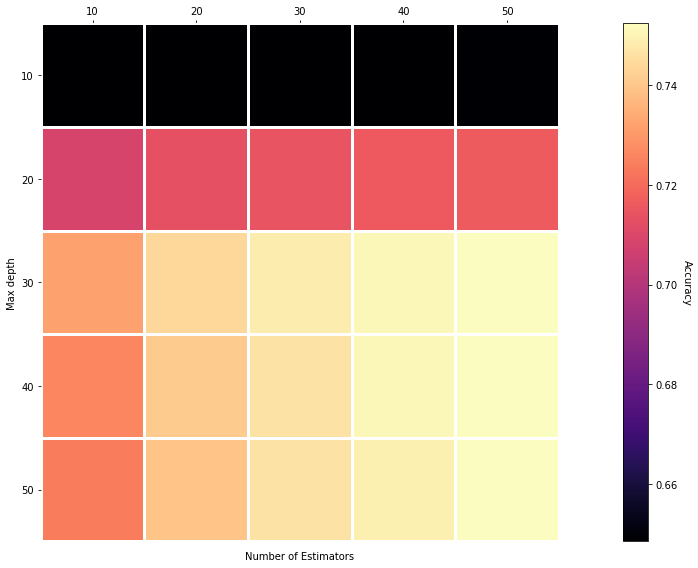

In [147]:
grid_results=np.array(RF_gs.cv_results_['mean_test_score']).\
                reshape((len(parameters['n_estimators']), len(parameters['max_depth'])))


#plotting
fig, axs = plt.subplots(1,1, figsize=(18,8)) 
im, cbar= heatmap(grid_results, parameters['max_depth'], parameters['n_estimators'], ax=axs,
            cmap="magma", cbarlabel="Accuracy")
axs.set(xlabel='Number of Estimators', \
           ylabel='Max depth')
fig.tight_layout()

In [148]:
RF_gs.cv_results_['mean_test_score']

array([0.64852336, 0.64856642, 0.6485333 , 0.64860728, 0.64893857,
       0.70869554, 0.71302431, 0.71462552, 0.71589213, 0.71635592,
       0.73179375, 0.74409321, 0.74870137, 0.75098833, 0.7520639 ,
       0.72630769, 0.7411746 , 0.74659992, 0.75076085, 0.75231899,
       0.72424821, 0.73950493, 0.74639563, 0.74950639, 0.75235653])

## Topics

We have identify a list of topic that are frequent and were a debat at the time. We will expore their behavior in the word space hopping to find clusters :
* Black lives matter, police brutality, police violence, blacktwitter, racism, NFL Protest, Jamar Clark, Alfredo Olango 
* me too, harvey weinstein, sexisme
* music, thefourhorsemen, album 
* Trump, Donald
* Hillary, HeforShe, IamWithHer, crookedHillary 
* religion
* fear, North Korea, Russia, Geopolotics
* Army, USAF
* fake news, cnn
* voter fraud
* terror, terrorist, attack, chicago, shootings, baltimore, bombings, Chattanooga
* hacking, emails, DNC
* Money, scandal, Wells Fargo, Imran Awan
* election, campaign, GOP, DNC, Dem, vote, I voted, debate, primary, national convention
* alt-righ, alt-left, Charlottesville, neo nazi
* economy, deal, Nafta
* music, thefourhorsemen, album, fm, nowplaying


In [316]:
model.wv.most_similar(stemmer.stem("police"))

KeyError: "word 'polic' not in vocabulary"

[me too, harvey weinstein, sexisme],
[music, thefourhorsemen, album], 
[Trump, Donald] ,
[Hillary, HeforShe, IamWithHer, crookedHillary], 
[religion], 
[fear, North Korea, Russia, Geopolotics], 
[Army, USAF], 
[fake news, cnn],
[voter fraud], 
[terror, terrorist, attack, chicago, shootings, baltimore, bombings, Chattanooga],
[hacking, emails, DNC], 
[Money, scandal, Wells Fargo, Imran Awan], 
[election, campaign, GOP, DNC, Dem, vote, I voted, debate, primary, national convention], 
[alt-righ, alt-left, Charlottesville, neo nazi],
[economy, deal, Nafta],
[music, thefourhorsemen, album, fm, nowplaying]